In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import zipfile
import os

# Paths
zip_path = '/content/archive.zip'   # Path to your archive.zip
extract_path = '/content/train_only/'  # Where you want to extract

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Loop through all files inside the zip
    for member in zip_ref.namelist():
        # If the file/folder starts with "train/", extract it
        if member.startswith('train/'):
            zip_ref.extract(member, extract_path)

# Let's check if it worked
print(os.listdir(extract_path))
print(os.listdir(os.path.join(extract_path, 'train')))

['train']
['disgusted', 'surprised', 'neutral', 'happy', 'angry', 'fearful', 'sad']


In [ ]:
train_dir = '/content/train_only/train'

In [ ]:
# Image size and batch size
img_width, img_height = 48, 48
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1/255.0,
        rotation_range=30,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        shear_range=0.15,
        validation_split=0.2  # 20% images used for validation
    )

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True,
        subset='training',
        seed=42
    )

Found 22968 images belonging to 7 classes.


In [ ]:
valid_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False,
        subset='validation',
        seed=42
    )

Found 5741 images belonging to 7 classes.


In [ ]:
batch_size = 128
lr = 1e-3
epochs = 300
num_classes = 7

In [ ]:
!pip install tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import Model
# other imports...


training_weights = './weights/'
checkpoint_period = ModelCheckpoint(
        training_weights + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.weights.h5',
        monitor='val_loss',
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )
reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=1e-6
    )

early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

tensorboard = TensorBoard(log_dir='./logs') # Assumed log directory

optimizer = Adam(learning_rate=lr)

# ... rest of your code ...

In [ ]:
def create_model(input_shape=(48, 48, 1), num_classes=7):
    input = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(num_classes, activation='softmax')(x)

    return Model(input, output, name='fer_gpu_model')

In [ ]:
optimizer = Adam(learning_rate=0.001)
model = create_model()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy']
    )

In [ ]:
model.summary()

Model: "fer_gpu_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 12,543,511 (47.85 MB)

 Trainable params: 4,179,847 (15.94 MB)

 Non-trainable params: 3,968 (15.50 KB)

 Optimizer params: 8,359,696 (31.89 MB)

In [ ]:
model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=epochs,
        callbacks=[tensorboard, early_stopping, reduce_lr, checkpoint_period],
        verbose=1
    )

Epoch 1/300
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.1932 - loss: 2.4535
Epoch 1: val_loss improved from inf to 2.01271, saving model to ./weights/ep001-loss2.260-val_loss2.013.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 74s 156ms/step - accuracy: 0.1932 - loss: 2.4529 - val_accuracy: 0.2507 - val_loss: 2.0127 - learning_rate: 0.0010
Epoch 2/300
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2197 - loss: 1.9894
Epoch 2: val_loss improved from 2.01271 to 1.89063, saving model to ./weights/ep002-loss1.936-val_loss1.891.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - accuracy: 0.2198 - loss: 1.9893 - val_accuracy: 0.2527 - val_loss: 1.8906 - learning_rate: 0.0010
Epoch 3/300
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2529 - loss: 1.8354
Epoch 3: val_loss did not improve from 1.89063
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.2529 - loss: 1.8354 - val_accuracy: 0.2446 - val_loss: 2.3922 - learning_rate: 0.0010
Epoch 4/300
359/359 ━━

In [ ]:
# Assuming 'validation_generator' is your previously defined validation data
import numpy as np

# Define or re-initialize validation_generator here
# This should be the same code you used to create it initially
# Example:
#   from tensorflow.keras.preprocessing.image import ImageDataGenerator
#   validation_generator = ImageDataGenerator(...).flow_from_directory(...)

# ... (your validation_generator definition) ...

# Get all batches from validation_generator
X_test, y_test = [], []
for i in range(len(valid_generator)):
    batch_x, batch_y = valid_generator[i]
    X_test.append(batch_x)
    y_test.append(batch_y)

# Concatenate batches into a single numpy array
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Now you can evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.6024 - loss: 1.0846
Test Accuracy: 66.78%


In [ ]:
model.save("emotion_model.h5")

In [ ]:
from google.colab import files  # Import the files object

print("\nPlease upload the music dataset (song_MOODMELODY):")
uploaded_music = files.upload()


Please upload the music dataset (song_MOODMELODY):


Saving songs_MOODMELODY.zip to songs_MOODMELODY.zip


In [ ]:
# Extract the datasets
music_extract_path = '/content/music_data'

In [ ]:
# Create directories if they don't exist
!mkdir -p {music_extract_path}

In [ ]:
# Extract the music dataset
import zipfile
with zipfile.ZipFile('song_MOODMELODY', 'r') as zip_ref:
    zip_ref.extractall(music_extract_path)

FileNotFoundError: [Errno 2] No such file or directory: 'song_MOODMELODY'

In [ ]:
# Load the music dataset
import pandas as pd
music_data = pd.read_csv(f'{music_extract_path}/song_MOODMELODY')

FileNotFoundError: [Errno 2] No such file or directory: '/content/music_data/song_MOODMELODY'

In [ ]:
music_data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [ ]:
# Display basic information about the music dataset
print("Music dataset shape:", music_data.shape)
print("Music dataset columns:", music_data.columns.tolist())
print("Music dataset sample:")
print(music_data.head())

Music dataset shape: (169909, 19)
Music dataset columns: ['acousticness', 'artists', 'danceability', 'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo', 'valence', 'year']
Music dataset sample:
   acousticness                                   artists  danceability  \
0         0.995                       ['Carl Woitschach']         0.708   
1         0.994  ['Robert Schumann', 'Vladimir Horowitz']         0.379   
2         0.604                   ['Seweryn Goszczyński']         0.749   
3         0.995                      ['Francisco Canaro']         0.781   
4         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']         0.210   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       158648  0.1950         0  6KbQ3uYMLKb5jDxLF7wYDD             0.563   
1       282133  0.0135         0  6KuQTIu1KoTTkLXKrwlLPV             0.901   
2       1

In [ ]:
# Get the correct emotion class names from the dataset
emotion_classes = sorted(os.listdir(train_dir))
print("Emotion classes detected:", emotion_classes)# Get the correct emotion class names from the dataset
emotion_classes = sorted(os.listdir(train_dir))
print("Emotion classes detected:", emotion_classes)

Emotion classes detected: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Emotion classes detected: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
# Function to map emotions to music features
def map_emotion_to_music_features(emotion):
    # These mappings are based on common associations between emotions and music features
    emotion_mapping = {
        'angry': {
            'energy': 0.8,  # High energy for angry emotions
            'valence': 0.2,  # Low valence (happiness) for angry emotions
            'tempo': 140,    # Fast tempo for angry emotions
            'loudness': -5,  # Loud music for angry emotions
            'danceability': 0.5  # Moderate danceability
        },
        'disgust': {
            'energy': 0.7,
            'valence': 0.3,
            'tempo': 130,
            'loudness': -8,
            'danceability': 0.4
        },
        'fear': {
            'energy': 0.6,
            'valence': 0.2,
            'tempo': 100,
            'loudness': -10,
            'danceability': 0.3
        },
        'happy': {
            'energy': 0.7,
            'valence': 0.8,  # High valence for happy emotions
            'tempo': 120,
            'loudness': -6,
            'danceability': 0.7  # High danceability for happy emotions
        },
        'neutral': {
            'energy': 0.5,
            'valence': 0.5,
            'tempo': 110,
            'loudness': -10,
            'danceability': 0.5
        },
        'sad': {
            'energy': 0.3,  # Low energy for sad emotions
            'valence': 0.2,  # Low valence for sad emotions
            'tempo': 80,     # Slow tempo for sad emotions
            'loudness': -12,
            'danceability': 0.3
        },
        'surprise': {
            'energy': 0.8,
            'valence': 0.6,
            'tempo': 125,
            'loudness': -7,
            'danceability': 0.6
        }
    }

    return emotion_mapping.get(emotion, emotion_mapping['neutral'])


In [ ]:
# Function to recommend songs based on detected emotion
def recommend_songs_by_emotion(emotion, music_data, num_recommendations=10):
    # Get the preferred music features for the detected emotion
    preferred_features = map_emotion_to_music_features(emotion)

    # Create a copy of the music data to avoid modifying the original
    music_df = music_data.copy()

    # Calculate similarity scores based on the preferred features
    # We'll use a simple Euclidean distance for each feature and normalize them

    # Normalize each feature before calculating distance
    def min_max_scale(x, feature_name):
        min_val = music_df[feature_name].min()
        max_val = music_df[feature_name].max()
        return (x - min_val) / (max_val - min_val) if max_val > min_val else 0

    # Calculate distances for each feature
    music_df['energy_dist'] = music_df['energy'].apply(
        lambda x: abs(x - preferred_features['energy'])
    )
    music_df['valence_dist'] = music_df['valence'].apply(
        lambda x: abs(x - preferred_features['valence'])
    )
    music_df['tempo_dist'] = music_df['tempo'].apply(
        lambda x: min_max_scale(abs(x - preferred_features['tempo']), 'tempo')
    )
    music_df['loudness_dist'] = music_df['loudness'].apply(
        lambda x: min_max_scale(abs(x - preferred_features['loudness']), 'loudness')
    )
    music_df['danceability_dist'] = music_df['danceability'].apply(
        lambda x: abs(x - preferred_features['danceability'])
    )

    # Calculate overall distance (weighted sum of individual distances)
    # You can adjust the weights based on which features you think are more important
    music_df['total_dist'] = (
        music_df['energy_dist'] * 0.25 +
        music_df['valence_dist'] * 0.3 +
        music_df['tempo_dist'] * 0.15 +
        music_df['loudness_dist'] * 0.1 +
        music_df['danceability_dist'] * 0.2
    )

    # Sort by total distance (ascending) and get the top recommendations
    recommendations = music_df.sort_values('total_dist').head(num_recommendations)

    # Return only necessary columns
    return recommendations[['name', 'artists', 'danceability', 'energy', 'valence', 'tempo']]

In [ ]:
# Function to predict emotion from a facial image
def predict_emotion(image_path, model):
    from tensorflow.keras.preprocessing import image
    import numpy as np

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make prediction
    predictions = model.predict(img_array)

    # Get the emotion class
    predicted_class = emotion_classes[np.argmax(predictions)]

    return predicted_class, predictions

In [ ]:
# Demo function to test the entire pipeline
def demo_mood_based_recommendation(image_path, model, music_data):
    # Predict emotion from the image
    emotion, confidence = predict_emotion(image_path, model)
    print(f"Detected emotion: {emotion}")

    # Get music recommendations based on the detected emotion
    recommendations = recommend_songs_by_emotion(emotion, music_data)

    # Display recommendations
    print("\nRecommended songs based on your mood:")
    for i, (_, row) in enumerate(recommendations.iterrows(), 1):
        print(f"{i}. {row['name']} by {row['artists']}")

    return emotion, recommendations

In [ ]:
# Simple UI to test the system with a sample image
def upload_and_predict():
    from google.colab import files
    from IPython.display import display, Image
    import matplotlib.pyplot as plt

    # Upload image
    print("Please upload a facial image to detect mood:")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Display uploaded image
        print(f"Uploaded image: {filename}")
        display(Image(filename))

        # Predict emotion and get recommendations
        emotion, recommendations = demo_mood_based_recommendation(filename, model, music_data)

        # Show detailed recommendations
        plt.figure(figsize=(10, 6))
        for i, (_, row) in enumerate(recommendations.head(5).iterrows()):
            plt.bar(i, row['energy'], label='Energy' if i == 0 else "")
            plt.bar(i, row['valence'], bottom=row['energy'], label='Valence' if i == 0 else "")
            plt.text(i, 0.5, f"{row['name']}\n{row['artists']}", ha='center', va='center', rotation=90)

        plt.xlabel('Songs')
        plt.ylabel('Feature Values')
        plt.title(f'Top 5 Recommendations for {emotion.capitalize()} Mood')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
# Full pipeline function
def run_mood_based_music_recommendation():
    print("Mood-Based Music Recommendation System")
    print("======================================")
    print("1. Upload a facial image to detect mood")
    print("2. Get personalized music recommendations")
    print("\nUploading interface will appear below:")

    # Call the upload and predict function
    upload_and_predict()

Mood-Based Music Recommendation System
1. Upload a facial image to detect mood
2. Get personalized music recommendations

Uploading interface will appear below:
Please upload a facial image to detect mood:


Saving im8.png to im8.png
Uploaded image: im8.png


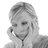

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Detected emotion: happy

Recommended songs based on your mood:
1. Goodbye Earl by ['Dixie Chicks']
2. Shine by ['Sonny Davis']
3. Die Young by ['Kesha']
4. When Boy Meets Girl by ['Terri Clark']
5. Winning the War by ["'Til Tuesday"]
6. Philadelphia Freedom by ['Elton John']
7. That Same Old Feeling by ['The Foundations']
8. Preta Pretinha by ['Novos Baianos']
9. My Maria by ['B.W. Stevenson']
10. Philadelphia Freedom by ['Elton John']


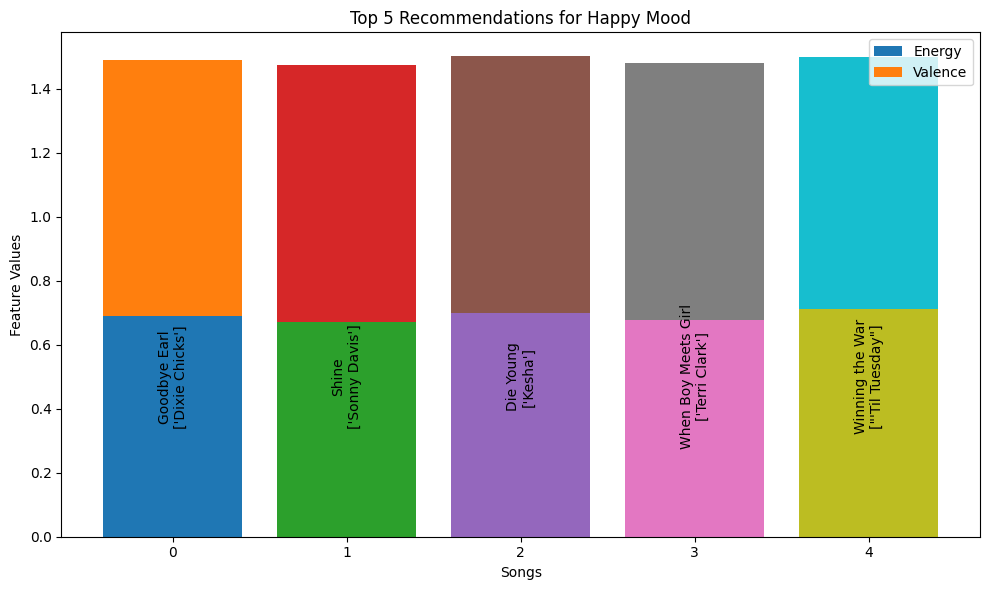

In [ ]:
# Run the system
run_mood_based_music_recommendation()

In [ ]:
model.save("MOODMELODY_model.h5")

In [ ]:
from google.colab import files
files.download("MOODMELODY_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>